In [1]:
cd modules

/home/dadmaan/Documents/dev/py_music/genre_classifier/modules


In [2]:
import os
import datetime

import utils
import data_loader
import helper
from helper import F1Score
from genre_classifier_m4 import CNNModel
import IPython.display as ipd

import pandas as pd
import librosa
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelBinarizer

# %load_ext tensorboard
import tensorflow as tf
import tensorflow_datasets as tfds
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [4]:
# FMA Dataset 
DIR = '/run/media/dadmaan/Seagate Backup Plus Drive/datasets/fma'
METADATA = os.path.join(DIR, 'fma_metadata')

tracks = utils.load(os.path.join(METADATA, 'tracks.csv'))
features = utils.load(os.path.join(METADATA, 'features.csv'))
genres = utils.load(os.path.join(METADATA, 'genres.csv'))

# Training
DS_TRAIN = 6400
DS_VALID = 800
DS_TEST = 800

SAMPLE_RATE = 22050
DURATION = 10
EPOCHS = 20
BATCH_SIZE = 64
SHUFFLE_SIZE = 2 * BATCH_SIZE
STEPS_TRAIN = DS_TRAIN / BATCH_SIZE
STEPS_VALID = DS_VALID / BATCH_SIZE
STEPS_TEST = DS_TEST / BATCH_SIZE

## Data-set Prepration

In [5]:
train_data = data_loader.get_dataset_from_tfrecords(split='train', 
                                                    duration = DURATION, 
                                                    sample_rate=SAMPLE_RATE)

valid_data = data_loader.get_dataset_from_tfrecords(split='valid', 
                                                    duration = DURATION, 
                                                    sample_rate=SAMPLE_RATE)

test_data = data_loader.get_dataset_from_tfrecords(split='test', 
                                                   duration = DURATION, 
                                                   sample_rate=SAMPLE_RATE)

train_data, valid_data, test_data

(<PrefetchDataset shapes: ((None, 220500), (None, 8)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 220500), (None, 8)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 220500), (None, 8)), types: (tf.float32, tf.int64)>)

## Model Prepration

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 220500)]          0         
_________________________________________________________________
mel-spectrogram (MelSpectrog (None, 427, 128, 1)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 427, 128, 1)       512       
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 429, 130, 1)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 143, 43, 32)       320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 143, 43, 32)       128       
_________________________________________________________________
block1_pool1 (MaxPooling2D)  (None, 142, 42, 32)       0     

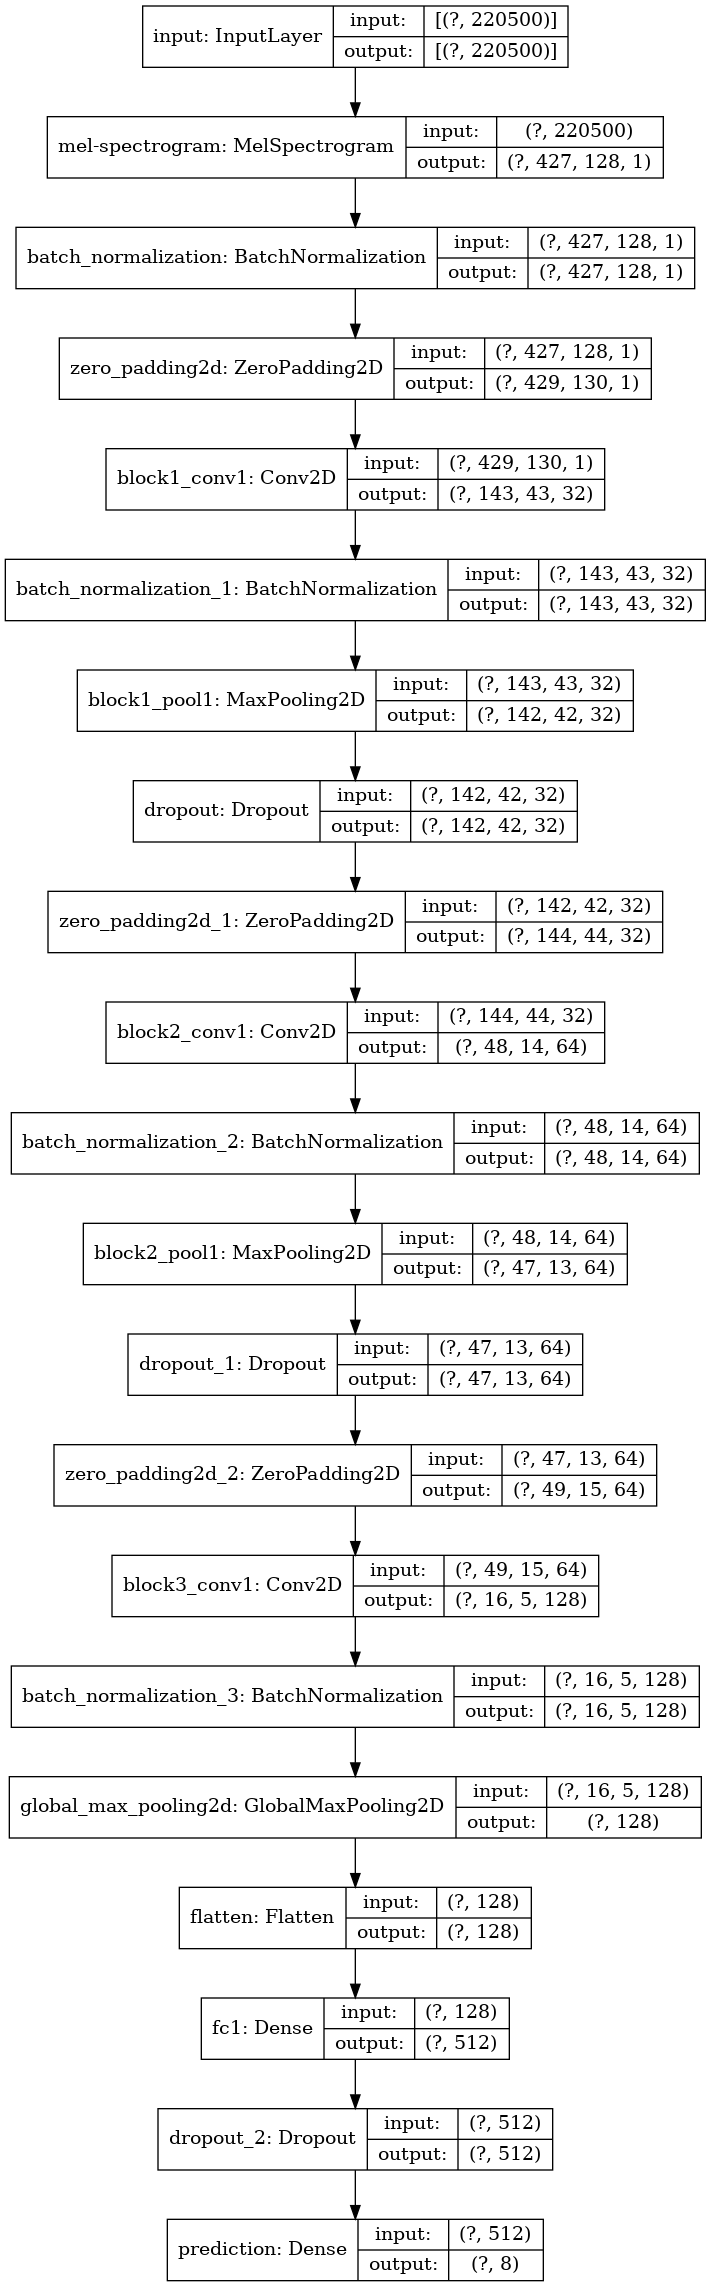

In [6]:
model = CNNModel(sample_rate=SAMPLE_RATE, duration=DURATION)

model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()
tf.keras.utils.plot_model(model, to_file='../visualization/genre_classifier_m4.png', 
                          show_shapes=True, 
                          show_layer_names=True)

## Load Weights

In [11]:
weights_path = '../weights/exp4_gc_weights.hdf5'
if os.path.exists(weights_path):
    model.load_weights(weights_path, by_name=False)
    print('Weights Loaded!')

Weights Loaded!


## Callbacks

In [8]:
# Keras
filepath = "../weights/exp4_gc_improvement_{epoch:02d}_{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(
    filepath,
    monitor='loss',
    verbose=0,
    save_best_only=True,
    save_weights_only=True,
    mode='min'
)

# Tensorboard
# log_dir = "logs" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard = tf.keras.callbacks.TensorBoard(
#     log_dir='log_dir', histogram_freq=1, write_graph=True, write_images=True,
#     update_freq='epoch', profile_batch=2, embeddings_freq=0,
#     embeddings_metadata=None
# )

# F1-Score
for features in valid_data:
    X_valid, y_valid = features[0], features[1]
    
validation_data = [X_valid, y_valid]
f1_score = F1Score(validation_data)


callbacks_list = [checkpoint, f1_score]

## Train Model

In [12]:
history = model.fit(train_data, 
                    epochs=10, 
                    steps_per_epoch=STEPS_TRAIN,
                    validation_data=valid_data,
                    validation_steps=STEPS_VALID,
                    callbacks=callbacks_list)

helper.save_training_history('../logs/exp4_logs', history.history, f1_score.val_f1s)

Train for 100.0 steps, validate for 12.5 steps
Epoch 1/10
100/100 [==============================] - 775s 8s/step - loss: 0.7915 - accuracy: 0.7142 - val_loss: 1.9355 - val_accuracy: 0.4762
Epoch 2/10
100/100 [==============================] - 773s 8s/step - loss: 0.7801 - accuracy: 0.7161 - val_loss: 1.9212 - val_accuracy: 0.4712
Epoch 3/10
100/100 [==============================] - 779s 8s/step - loss: 0.7846 - accuracy: 0.7163 - val_loss: 1.8156 - val_accuracy: 0.4850
Epoch 4/10
100/100 [==============================] - 769s 8s/step - loss: 0.7466 - accuracy: 0.7266 - val_loss: 1.9690 - val_accuracy: 0.4850
Epoch 5/10
100/100 [==============================] - 768s 8s/step - loss: 0.7469 - accuracy: 0.7221 - val_loss: 1.9443 - val_accuracy: 0.4750
Epoch 6/10
100/100 [==============================] - 791s 8s/step - loss: 0.7556 - accuracy: 0.7299 - val_loss: 1.9764 - val_accuracy: 0.4950
Epoch 7/10
100/100 [==============================] - 744s 7s/step - loss: 0.7695 - accuracy: 0

ValueError: Length of passed values is 20, index implies 10

In [13]:
model.save_weights('../weights/exp4_gc_weights.hdf5')

## Evaluate Model

In [14]:
results = model.evaluate(test_data, steps=STEPS_TEST, callbacks=callbacks_list)
evaluation = pd.DataFrame(results)
evaluation.to_csv('../logs/exp4_evaluation_log.csv', index=False)

13/12 [===============================] - 76s 6s/step - loss: 1.8130 - accuracy: 0.5475


## Predictions

In [70]:
filename = utils.get_audio_path(os.path.join(DIR, 'fma_small'), 5)
print('File: {}'.format(filename))

x, sr = librosa.load(filename, sr=22050, mono=True, duration=10)
print('Duration: {:.2f}s, {} samples'.format(x.shape[-1] / sr, x.size))
ipd.Audio(data=x, rate=sr)

File: /run/media/dadmaan/Seagate Backup Plus Drive/datasets/fma/fma_small/000/000005.mp3


/home/dadmaan/.conda/envs/mc/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Duration: 10.00s, 220500 samples


In [74]:
x = x.reshape(1,x.shape[-1])
x.shape

(1, 220500)

In [72]:
predictions = model.predict(x)

In [73]:
predictions>0.5

array([[False,  True, False, False, False, False, False, False]])

In [38]:
columns = genres.reset_index().set_index('title')
columns = columns.loc[tracks.loc[small, ('track', 'genre_top')].unique()]

NameError: name 'small' is not defined

In [62]:
pred = pd.DataFrame(data=predictions[0:, 0:],
            columns=columns.index.values)
pred.to_csv('../logs/exp4_predictions_log.csv', index=False)

In [67]:
pred > 0.5

Hip-Hop    Pop   Folk  Experimental   Rock  International  Electronic  \
0      False  False  False         False  False          False       False   
1      False  False  False         False  False          False       False   
2      False  False  False         False  False          False       False   
3      False  False  False         False  False          False       False   
4      False  False  False         False  False          False       False   
..       ...    ...    ...           ...    ...            ...         ...   
795    False  False  False         False  False          False       False   
796    False  False  False         False  False           True       False   
797    False  False  False         False  False          False       False   
798    False  False  False          True  False          False       False   
799    False  False  False         False  False          False       False   

     Instrumental  
0           False  
1           False  
2           False  
3           False  
4           False  
..            ...  
795         False  
796         False  
797         False  
798         False  
799         False  

[800 rows x 8 columns]